In [1]:
import os
import re
import time
import json
from collections import defaultdict

import scipy as sc
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


In [2]:
BASE_DIR = os.path.dirname(os.path.abspath('.'))
DATA_DIR = os.path.join(BASE_DIR, 'datas')

## Data Description

In [3]:
uscv_edgelist_fpath = os.path.join(DATA_DIR, 'bill_0-1800_edgelist.tsv')
uscv_edgeinfo_fpath = os.path.join(DATA_DIR, 'bill_edgeinfo.tsv')
uscv_nodeinfo_fpath = os.path.join(DATA_DIR, 'bill_nodeinfo.tsv')

In [4]:
edge_df = pd.read_csv(uscv_edgelist_fpath, sep='\t')

In [5]:
edge_df

,PersonIdA,PersonIdB,Sign,Time,Note
0,401379,401379,1,1789-08-21,-congress-votes-1-1-h10~NO~NO
1,401379,401623,1,1789-08-21,-congress-votes-1-1-h10~NO~NO
2,401379,401881,1,1789-08-21,-congress-votes-1-1-h10~NO~NO
3,401379,402174,1,1789-08-21,-congress-votes-1-1-h10~NO~NO
4,401379,402334,1,1789-08-21,-congress-votes-1-1-h10~NO~NO
...,...,...,...,...,...
2918846,412146,411193,1,1800-12-22,-congress-votes-6-2-h58~YEA~YEA
2918847,412146,411874,1,1800-12-22,-congress-votes-6-2-h58~YEA~YEA
2918848,412146,412031,1,1800-12-22,-congress-votes-6-2-h58~YEA~YEA
2918849,412146,412131,1,1800-12-22,-congress-votes-6-2-h58~YEA~YEA


In [6]:
edgeinfo_df = pd.read_csv(uscv_edgeinfo_fpath, sep='\t')

In [7]:
edgeinfo_df

,Note,Info
0,-congress-votes-1-1-h10,"{""features"": [""chamber-House"", ""session-1789-M..."
1,-congress-votes-1-1-h11,"{""features"": [""chamber-House""], ""url"": ""https:..."
2,-congress-votes-1-1-h12,"{""features"": [""category-Unknown-Category"", ""ch..."
3,-congress-votes-1-1-h13,"{""features"": [""category-Unknown-Category"", ""ch..."
4,-congress-votes-1-1-h14,"{""features"": [""category-Unknown-Category"", ""ch..."
...,...,...
108181,-congress-votes-99-1986-s736,"{""features"": [""category-Unknown-Category"", ""ch..."
108182,-congress-votes-99-1986-s737,"{""features"": [""category-Unknown-Category"", ""ch..."
108183,-congress-votes-99-1986-s738,"{""features"": [""category-Unknown-Category"", ""ch..."
108184,-congress-votes-99-1986-s739,"{""features"": [""category-Unknown-Category"", ""ch..."


In [8]:
print(json.loads(edgeinfo_df.iloc[0]['Info']))

{'features': ['chamber-House', 'session-1789-Mar-Sep-(1st-Congress)'], 'url': 'https://www.govtrack.us/congress/votes/1-1/h10', 'title': 'TO AMEND THE CONSTITUTIONAL AMENDMENTS RESOLUTION TO ADD THE WORD "EXPRESSLY" SO AS TO READ "THE POWERS NOT EXPRESSLY DELEGATED BY THE CONSTITUTION, NOR PROHIBITED TO THE STATES. ...".', 'date': 'Aug 21, 1789 .'}


In [9]:
nodeinfo_df = pd.read_csv(uscv_nodeinfo_fpath, sep='\t')

In [10]:
nodeinfo_df

,PersonId,Info
0,300001,"{""person"": 300001, ""state"": ""HI"", ""district"": ..."
1,300002,"{""person"": 300002, ""state"": ""TN"", ""district"": ..."
2,300003,"{""person"": 300003, ""state"": ""CO"", ""district"": ..."
3,300004,"{""person"": 300004, ""state"": ""VA"", ""district"": ..."
4,300005,"{""person"": 300005, ""state"": ""MT"", ""district"": ..."
...,...,...
12298,456791,"{""person"": 456791, ""state"": ""WI"", ""district"": ..."
12299,456792,"{""person"": 456792, ""state"": ""CA"", ""district"": ..."
12300,456793,"{""person"": 456793, ""state"": ""NY"", ""district"": ..."
12301,456794,"{""person"": 456794, ""state"": ""AZ"", ""district"": ..."


In [11]:
print(json.loads(nodeinfo_df.iloc[0]['Info']))

{'person': 300001, 'state': 'HI', 'district': 2, 'name': 'Rep. Daniel Akaka [D, 1977-1990]', 'party': 'Democrat', 'url': 'https://www.govtrack.us/congress/members/daniel_akaka/300001'}


### Original Vote Data
As we said in the paper, the dataset is constructed from vote data.
We give the origin dataset as follows.

In [12]:
vote_data_path = os.path.join(DATA_DIR, 'bill_a_c_clean.tsv')

In [13]:
vote_df = pd.read_csv(vote_data_path, sep='\t')

In [14]:
vote_df

,Unnamed: 0,person_id,bill_name,sign,date,title,year
0,0,400951,-congress-votes-1-1-h10,NOT VOTING,1789-08-21,TO AMEND THE CONSTITUTIONAL AMENDMENTS RESOLUT...,1789
1,1,401086,-congress-votes-1-1-h10,NOT VOTING,1789-08-21,TO AMEND THE CONSTITUTIONAL AMENDMENTS RESOLUT...,1789
2,2,401379,-congress-votes-1-1-h10,NO,1789-08-21,TO AMEND THE CONSTITUTIONAL AMENDMENTS RESOLUT...,1789
3,3,401521,-congress-votes-1-1-h10,NOT VOTING,1789-08-21,TO AMEND THE CONSTITUTIONAL AMENDMENTS RESOLUT...,1789
4,4,401537,-congress-votes-1-1-h10,NOT VOTING,1789-08-21,TO AMEND THE CONSTITUTIONAL AMENDMENTS RESOLUT...,1789
...,...,...,...,...,...,...,...
24821300,24821300,410936,-congress-votes-99-1986-s739,YEA,1986-10-17,"TO ADOPT THE CONFERENCE REPORT ON HR 5300, THE...",1986
24821301,24821301,411271,-congress-votes-99-1986-s739,YEA,1986-10-17,"TO ADOPT THE CONFERENCE REPORT ON HR 5300, THE...",1986
24821302,24821302,411421,-congress-votes-99-1986-s739,NOT VOTING,1986-10-17,"TO ADOPT THE CONFERENCE REPORT ON HR 5300, THE...",1986
24821303,24821303,411762,-congress-votes-99-1986-s739,YEA,1986-10-17,"TO ADOPT THE CONFERENCE REPORT ON HR 5300, THE...",1986


## Data Analysis

### House or Senate

In [15]:
vote_df['category'] = vote_df['bill_name'].apply(lambda x:x.rpartition('-')[-1][0])

In [16]:
vote_df.category.value_counts()

h    20561951
s     4259354
Name: category, dtype: int64

### Bill  Counts

In [17]:
t = list(map(lambda x:x.rpartition('-')[-1][0], vote_df['bill_name'].unique().tolist()))

In [18]:
from collections import Counter
c_t = Counter(t)

<BarContainer object of 2 artists>

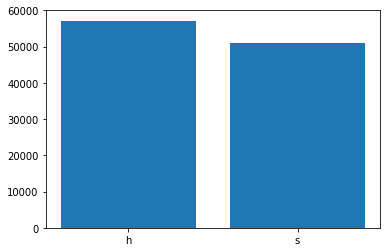

In [19]:
plt.bar(c_t.keys(), c_t.values())

### Sign Ratio

In [20]:
vote_df[vote_df['category'] == 'h']['sign'].value_counts()

YEA           11045187
NO             6554440
NOT VOTING     2674212
PRESENT         287399
UNKNOWN            713
Name: sign, dtype: int64

In [21]:
vote_df[vote_df['category'] == 's']['sign'].value_counts()

YEA           2039271
NO            1454824
NOT VOTING     727177
PRESENT         38079
UNKNOWN             3
Name: sign, dtype: int64

In [22]:
vote_df['year'] = vote_df['date'].apply(lambda x: int(x.split('-')[0]))

In [23]:
df_s = vote_df[vote_df['category'] == 's']
df_h = vote_df[vote_df['category'] == 'h']

### Time Span

#### Senate

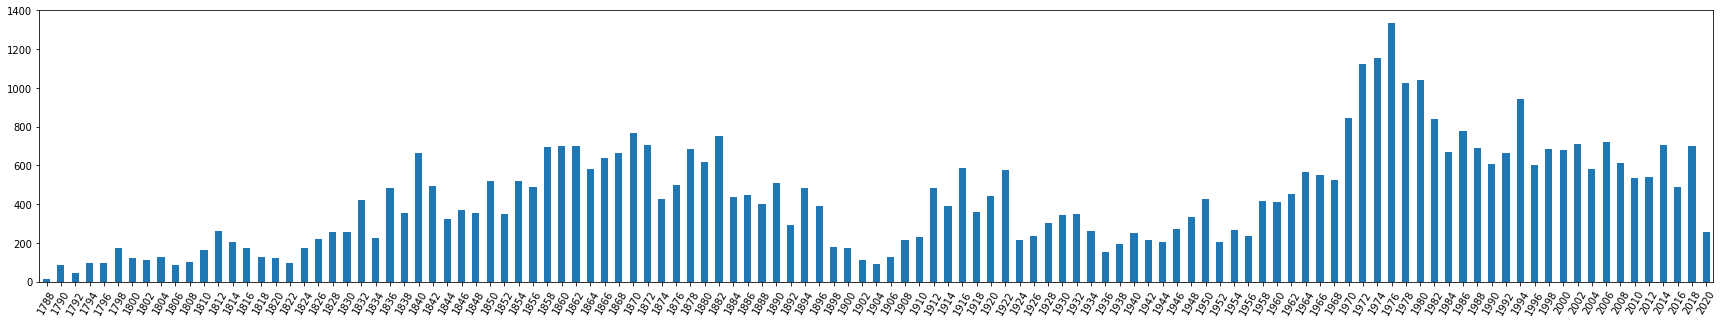

In [24]:
df_s_tmp = df_s.groupby('bill_name').agg({'year': 'mean'}).reset_index()
ax = df_s_tmp['year'].apply(lambda x: x // 2 * 2).value_counts().sort_index().plot(kind='bar', figsize=(30,5), rot=60)
# t = ax.get_xaxis().get_ticklabels()
# t2 = [int(i.get_text()) * 2 for i in t]
# ax.set_xticklabels(t2, rotation=45)

#### House

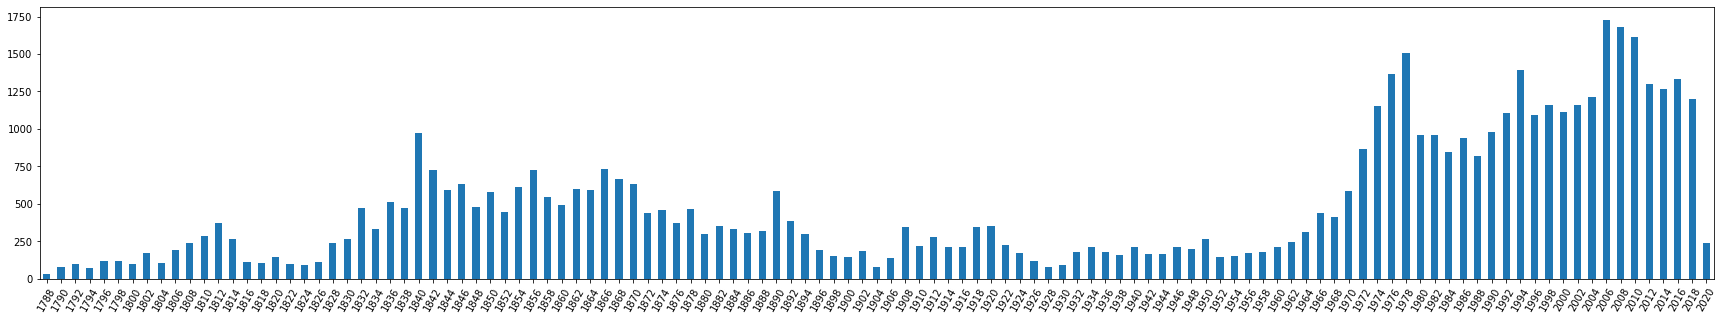

In [25]:
df_h_tmp = df_h.groupby('bill_name').agg({'year': 'mean'}).reset_index()
ax = df_h_tmp['year'].apply(lambda x: x // 2 * 2).value_counts().sort_index().plot(kind='bar', figsize=(30,5), rot=60)
# t = ax.get_xaxis().get_ticklabels()
# t2 = [int(i.get_text()) * 2 for i in t]
# ax.set_xticklabels(t2, rotation=45)

### Negative Link Ratio with Time

#### Senate

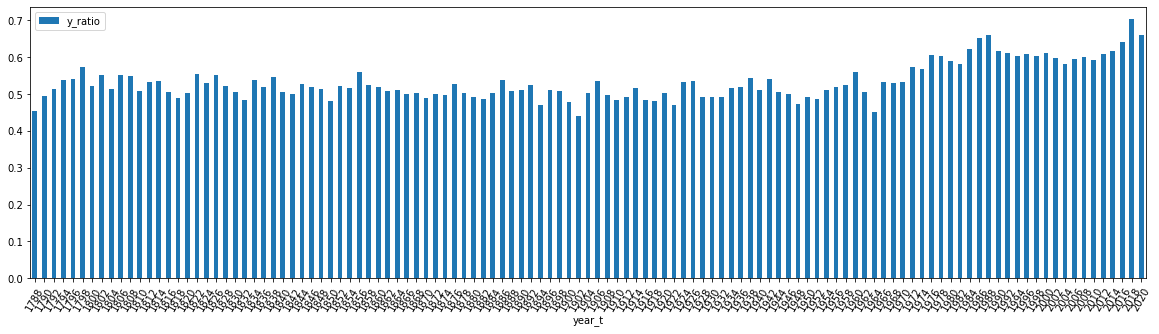

In [26]:
df_s1 = df_s[df_s['sign'] == "YEA"].groupby('bill_name').agg({'year': 'mean', 'sign': 'count'}).reset_index()
df_s1.rename(columns={'sign': 'Y_c'}, inplace=True)
df_s2 = df_s[df_s['sign'] == 'NO'].groupby('bill_name').agg({'year': 'mean', 'sign': 'count'}).reset_index()
df_s2.rename(columns={'sign': 'N_c'}, inplace=True)
df_s3 = df_s1.merge(df_s2, on='bill_name')
df_s3['y_ratio'] = df_s3['Y_c']/ (df_s3['N_c'] + df_s3['Y_c'])
df_s3['year_t'] = df_s3['year_x'].apply(lambda x: x//2 * 2)
ax = df_s3[['year_t', 'y_ratio']].groupby('year_t').agg({'y_ratio':'mean'}).plot.bar(figsize=(20,5), rot=60)
# t = ax.get_xaxis().get_ticklabels()


#### House

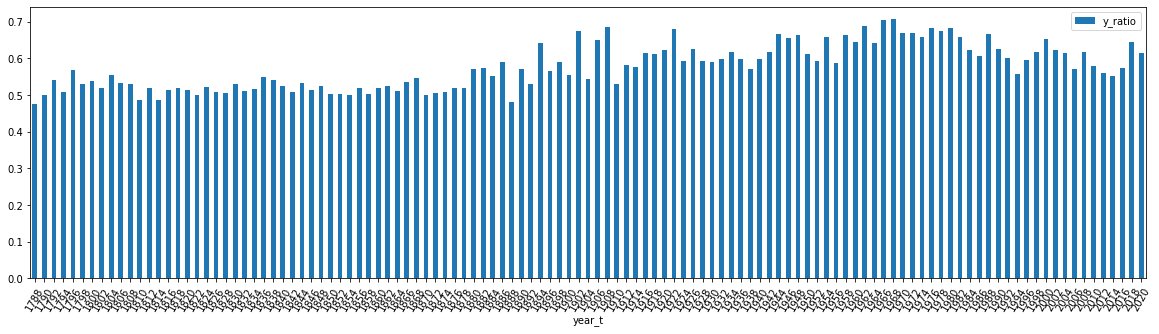

In [27]:
df_h1 = df_h[df_h['sign'] == "YEA"].groupby('bill_name').agg({'year': 'mean', 'sign': 'count'}).reset_index()
df_h1.rename(columns={'sign': 'Y_c'}, inplace=True)
df_h2 = df_h[df_h['sign'] == 'NO'].groupby('bill_name').agg({'year': 'mean', 'sign': 'count'}).reset_index()
df_h2.rename(columns={'sign': 'N_c'}, inplace=True)
df_h3 = df_h1.merge(df_h2, on='bill_name')
df_h3['y_ratio'] = df_h3['Y_c']/ (df_h3['N_c'] + df_h3['Y_c'])
df_h3['year_t'] = df_h3['year_x'].apply(lambda x: x//2 * 2)
ax = df_h3[['year_t', 'y_ratio']].groupby('year_t').agg({'y_ratio':'mean'}).plot.bar(figsize=(20,5),  rot=60)